In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_network, Flatten, View, weight_reset,  set_seed

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

In [3]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images 
#Hidden layer size
n = 2 
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10

In [7]:
class TransposeLinear(nn.Module): #Our class extends nn.Module, all PyTorch layers must extend this. 
    def __init__(self, linearLayer, bias=True):
        """
        linearLayer: is the layer that we want to use the transpose of to produce the output of this layer. So the Linear layer represents W, and this layer represents W^T. This is accomplished via weight sharing by re-using the weights of linearLayer
        bias: if True, we will crease a new bias term b that is learned separately from what is in linearLayer. If false, we will not use any bias vector. 
        """
        super().__init__()
        
        #We create a new variable weight to store a _reference_ to the original weight term. 
        self.weight = linearLayer.weight
        if bias:
            #We need to create a new bias vector. By default, PyTorch knows how to update Modules and Parameters. Since tensors are not either, the Parameter class wraps the Tensor class, so that PyTorch knows that the values in this tensor need to be updated by gradient descent
            self.bias = nn.Parameter(torch.Tensor(linearLayer.weight.shape[1]))
        else:
            #The Parameter class can not take None as an input. So if we want the bias term to exist, but be  potentially unused, we can use the register_parameter function to create it. The important thing  here is that PyTorch always sees the same parameters regardless of what we set the arguments for the  Module are. 
            self.register_parameter('bias', None)
    
    #The forward function is the code that takes an input and produce an output. 
    def forward(self, x):
        #The F directory of PyTorch contains many _functions_ that are used by Modules. For example, the linear function  performs a linear transform when given an input (we use the transpose of our weights) and a bias (if `None`, it knows to not do anything ).
        return F.linear(x, self.weight.t(), self.bias)
#Caption: This class implements the Transpose operation $W^\top$. The matrix to transpose $W$ must be passed in as the `linearLayer` in the constructor. This way we can share weights between an original `nn.Linear` layer and this transposed version of that layer. 

In [8]:
#Since we will share the weights of the linear layer, lets define it separately
linearLayer = nn.Linear(D,  n, bias=False)
#The encoder just falltens and then uses the linear layer
pca_encoder = nn.Sequential(
    nn.Flatten(),
    linearLayer,
)
#The decoder uses our TransposeLinear layer + the now shared linearLayer object 
pca_decoder = nn.Sequential(
    TransposeLinear(linearLayer, bias=False),
    View(-1, 1, 28, 28)#Shape the data back to it's original form
)
#Define a final PCA model that is the sequence of an encoder, followed by a decoder
pca_model = nn.Sequential(
    pca_encoder,
    pca_decoder
)

In [9]:
nn.init.orthogonal_(linearLayer.weight)

Parameter containing:
tensor([[-0.0063, -0.0112, -0.0474,  ...,  0.0428,  0.0234, -0.0159],
        [-0.0503,  0.0659, -0.0364,  ...,  0.0330,  0.0096,  0.0341]],
       requires_grad=True)

In [10]:
mse_loss = nn.MSELoss() #Original loss function

def mseWithOrthoLoss(x, y):#our PCA loss function
    #Grabing W from the linearLayer object we saved earlier. 
    W = linearLayer.weight
    #The identity matrix that is the target for the regularized
    I = torch.eye(W.shape[0]).to(device)
    #compute the original loss $\ell_{\mathit{MSE}}(f(\boldsymbol{x}), \boldsymbol{x})$
    normal_loss =  mse_loss(x, y) 
    #compute the regularizer penalty $\ell_{\mathit{MSE}}(W^\top W, \boldsymbol{I})$
    regularization_loss = 0.1*mse_loss(torch.mm(W, W.t()), I)
    #return the sum of the two losses
    return normal_loss + regularization_loss

In [11]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x#just throw away the original label. 

In [12]:
train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [13]:
train_network(pca_model, mseWithOrthoLoss, train_loader, test_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,test loss
0,0,5.566653,0.064164,0.058364
1,1,10.916434,0.057958,0.057854
2,2,16.260524,0.057885,0.057790
3,3,21.628740,0.057885,0.057796
4,4,26.978174,0.057887,0.057851
5,5,32.332556,0.057888,0.057809
6,6,37.724591,0.057885,0.057850
7,7,43.088038,0.057890,0.057812
8,8,48.449742,0.057891,0.057786
9,9,53.818799,0.057889,0.057836


In [14]:
def encode_batch(encoder, dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and convers it to a new dimension
    dataset_to_encode: a PyTorch `Dataset` object that we want to convert. 

    Returns a tuple (projected, labels) where `projected` is the encoded version of the dataset, and `labels` are the original labels provided by the `dataset_to_encode`
    """
    #Create space to store the results
    projected = []
    labels = []
    #Switch to eval mode
    encoder = encoder.eval()
    #Switching to CPU mode for simplicty, but you don't have to. 
    encoder = encoder.cpu()
    with torch.no_grad():#We don't want to train, so torch.no_grad! 
        for x, y in  DataLoader(dataset_to_encode, batch_size=128):
            z = encoder(x.cpu()) #encode the original data
            projected.append( z.numpy() ) #store the encoded version & label
            labels.append( y.cpu().numpy().ravel() )
    #Turn the results into single large numpy arrays
    projected = np.vstack(projected)
    labels = np.hstack(labels)
    #return the results
    return projected, labels
#Now lets project our data
projected, labels = encode_batch(pca_encoder, test_data_xy)

<AxesSubplot:>

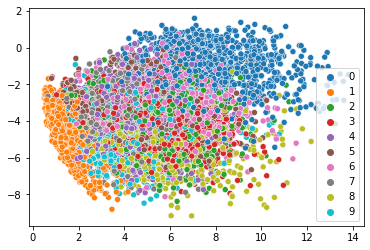

In [15]:
sns.scatterplot(x=projected[:,0], y=projected[:,1], hue=[str(l) for l in labels], hue_order=[str(i) for i in range(10)], legend="full")

In [16]:
def showEncodeDecode(encode_decode, x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding steps at once
    x: the input to plot as is, and after encoding & decoding it
    """
    #Switch to eval mode
    encode_decode = encode_decode.eval()
    #We will move things to the CPU so that we don't have to think about what device anything was on
    #and because this functino is not performance sensative
    encode_decode = encode_decode.cpu()
    with torch.no_grad():#Always no_grad if you are not training
        x_recon = encode_decode(x.cpu())
    #Use matplotlib to create a size-by-side plot with the original on the left
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])

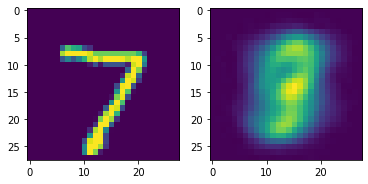

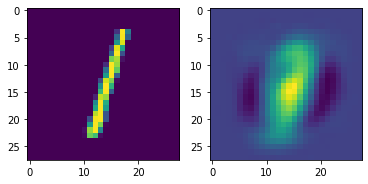

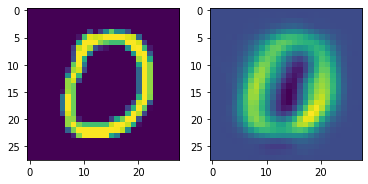

In [17]:
#Showing the input (left) and output (right) for three data points
showEncodeDecode(pca_model, test_data_xy[0][0])
showEncodeDecode(pca_model, test_data_xy[2][0])
showEncodeDecode(pca_model, test_data_xy[10][0])

In [18]:
#First the encoder is augmented by a Tanh non-linearity
pca_nonlinear_encode = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,  n),
    nn.Tanh(), #The only real change, ading a non-linear operation at the end
)
#The decoder gets its own Linear layer now, making it look more like a normal network
pca_nonlinear_decode = nn.Sequential(
    nn.Linear(n, D),#We are no longer tying the weights for simplicity 
    View(-1, 1, 28, 28)
)
#Combine then together into the encoder-decoder function $f(\cdot)$
pca_nonlinear = nn.Sequential(
    pca_nonlinear_encode,
    pca_nonlinear_decode
)

In [19]:
train_network(pca_nonlinear, mse_loss, train_loader, test_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,test loss
0,0,5.494894,0.136910,0.069512
1,1,10.929346,0.066531,0.065999
2,2,16.350923,0.065548,0.065414
3,3,21.784780,0.064869,0.064567
4,4,27.194329,0.063856,0.063260
5,5,32.613107,0.062291,0.061276
6,6,38.026129,0.060215,0.059063
7,7,43.440396,0.058485,0.057666
8,8,48.853819,0.057480,0.056911
9,9,54.284843,0.056926,0.056452


<AxesSubplot:>

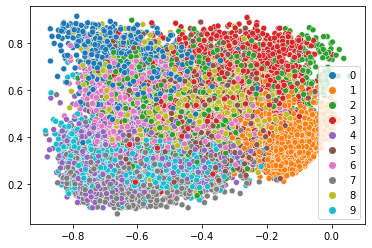

In [20]:
projected, labels = encode_batch(pca_nonlinear_encode, test_data_xy)
sns.scatterplot(x=projected[:,0], y=projected[:,1], hue=[str(l) for l in labels], hue_order=[str(i) for i in range(10)], legend="full" )

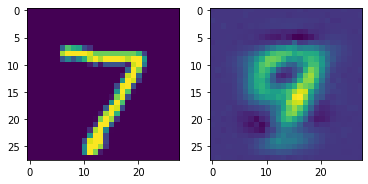

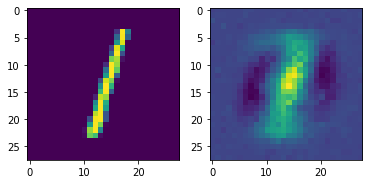

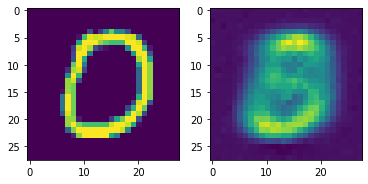

In [21]:
showEncodeDecode(pca_nonlinear, test_data_xy[0][0])
showEncodeDecode(pca_nonlinear, test_data_xy[2][0])
showEncodeDecode(pca_nonlinear, test_data_xy[10][0])

In [22]:
def getLayer(in_size, out_size):
    """
    in_size: how many neurons/features are coming into this layer
    out_size: how many neurons/outputs this hidden layer should produce
    """
    return nn.Sequential( #Organize the conceptual "block" of a hidden layer into a Sequential object
        nn.Linear(in_size,  out_size),
        nn.BatchNorm1d(out_size),
        nn.ReLU())

In [23]:
#Dividing by 2, 3, 4, is one of many patterns that could have been used
auto_encoder = nn.Sequential(
    nn.Flatten(),
    getLayer(D, D//2), #Each of these layers has a smaller output size than the previous
    getLayer(D//2, D//3),
    getLayer(D//3, D//4),
    nn.Linear(D//4,  n), #Jump down to the target dimension
)

#Decoder will do the same layers/sizes in reverse now to be symmetric 
auto_decoder = nn.Sequential(
    getLayer(n, D//4), #Each layer now increases in size because we are in the decoder. 
    getLayer(D//4, D//3),
    getLayer(D//3, D//2),
    nn.Linear(D//2,  D),
    View(-1, 1, 28, 28) #Reshape to match the original shape
)
#Combine into a deep auto encoder
auto_encode_decode = nn.Sequential(
    auto_encoder,
    auto_decoder
)

In [24]:
train_network(auto_encode_decode, mse_loss, train_loader, test_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,test loss
0,0,7.730793,0.049676,0.043066
1,1,15.466802,0.043251,0.041109
2,2,23.208247,0.041897,0.040083
3,3,30.924182,0.040945,0.039385
4,4,38.641290,0.040142,0.038731
5,5,46.396322,0.039692,0.038047
6,6,54.174958,0.039168,0.038352
7,7,61.943959,0.038845,0.037356
8,8,69.720815,0.038626,0.037213
9,9,77.453642,0.038262,0.036980


<AxesSubplot:>

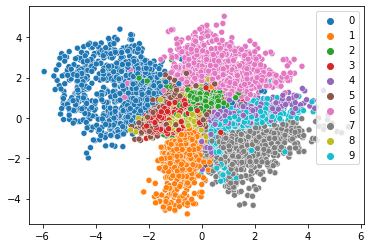

In [25]:
projected, labels = encode_batch(auto_encoder, test_data_xy)
sns.scatterplot(x=projected[:,0], y=projected[:,1], hue=[str(l) for l in labels], hue_order=[str(i) for i in range(10)], legend="full")

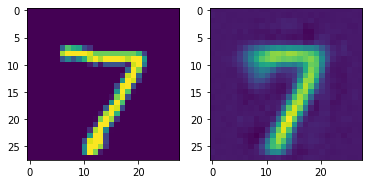

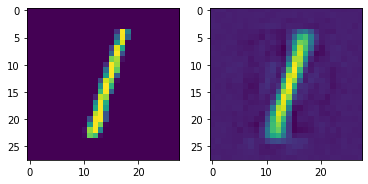

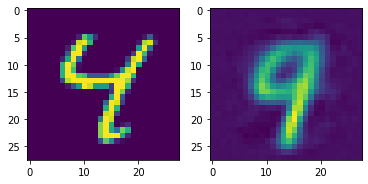

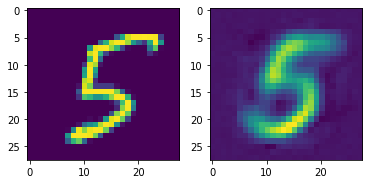

In [26]:
showEncodeDecode(auto_encode_decode, test_data_xy[0][0])
showEncodeDecode(auto_encode_decode, test_data_xy[2][0])
showEncodeDecode(auto_encode_decode, test_data_xy[6][0])
showEncodeDecode(auto_encode_decode, test_data_xy[23][0])

In [27]:
auto_encoder_big = nn.Sequential(
    nn.Flatten(),
    getLayer(D, D*2),
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    nn.Linear(D*2,  D*2),
)

auto_decoder_big = nn.Sequential(
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    nn.Linear(D*2,  D),
    View(-1, 1, 28, 28)
)

auto_encode_decode_big = nn.Sequential(
    auto_encoder_big,
    auto_decoder_big
)

In [28]:
train_network(auto_encode_decode_big, mse_loss, train_loader, test_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,test loss
0,0,8.774644,0.023708,0.013153
1,1,17.559084,0.013297,0.011388
2,2,26.388717,0.010333,0.009148
3,3,35.170645,0.009183,0.007777
4,4,43.981399,0.008505,0.015456
5,5,52.685799,0.010508,0.007427
6,6,61.160714,0.008124,0.006966
7,7,69.628340,0.007950,0.006946
8,8,78.103331,0.007147,0.006502
9,9,86.591652,0.006950,0.006266


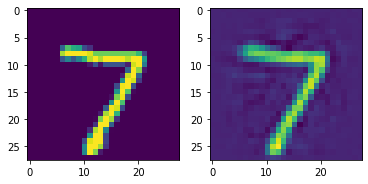

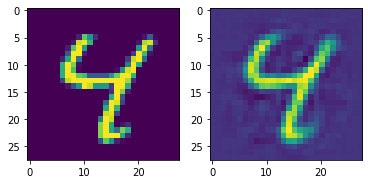

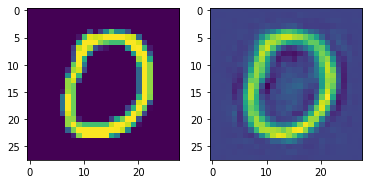

In [29]:
showEncodeDecode(auto_encode_decode_big, test_data_xy[0][0])
showEncodeDecode(auto_encode_decode_big, test_data_xy[6][0])
showEncodeDecode(auto_encode_decode_big, test_data_xy[10][0])

In [30]:
normal = torch.distributions.Normal(0, 0.5)#first argument is the mean $\mu$, second is the standard deviation $\sigma$

In [31]:
def addNoise(x, device='cpu'): 
    """
    We will use this helper function to add noise to some data. 
    x: the data we want to add noise to
    device: the CPU or GPU that the input is located on. 
    """
    return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device) #$\boldsymbol{x} + s$

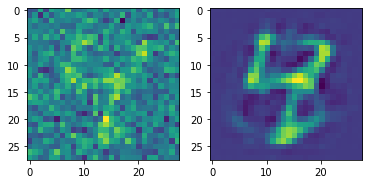

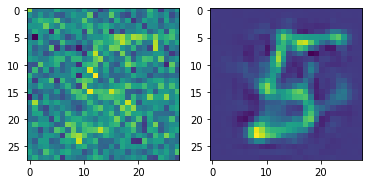

In [32]:
showEncodeDecode(auto_encode_decode_big, addNoise(test_data_xy[6][0]))
showEncodeDecode(auto_encode_decode_big, addNoise(test_data_xy[23][0]))

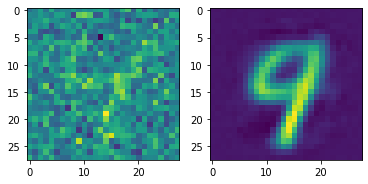

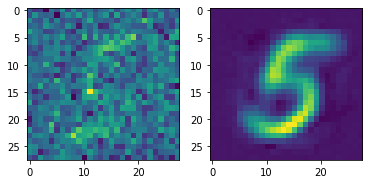

In [33]:
showEncodeDecode(auto_encode_decode, addNoise(test_data_xy[6][0]))
showEncodeDecode(auto_encode_decode, addNoise(test_data_xy[23][0]))

In [34]:
class AdditiveGausNoise(nn.Module):
    def __init__(self):
        super().__init__()
        #We don't need to do anything in the constructor of this object. 
        
    def forward(self, x):
        #every PyTorch Module object has a self.training boolean which can be used  to check if we are in training (True) or evaluation (False) mode. 
        if self.training:
             return addNoise(x, device=device)
        else: #Now training, return the data as it was given
            return x

In [35]:
dnauto_encoder_big = nn.Sequential(
    nn.Flatten(),
    AdditiveGausNoise(), #Only addition! Inserting noise here hopefully helps.
    getLayer(D, D*2),
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    nn.Linear(D*2,  D*2),
)

dnauto_decoder_big = nn.Sequential(
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    nn.Linear(D*2,  D),
    View(-1, 1, 28, 28)
)

dnauto_encode_decode_big = nn.Sequential(
    dnauto_encoder_big,
    dnauto_decoder_big
)
# Now we can train like normal. 
train_network(dnauto_encode_decode_big, mse_loss, train_loader, test_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,test loss
0,0,9.335304,0.031995,0.018335
1,1,18.569642,0.020973,0.015782
2,2,27.697530,0.018774,0.013159
3,3,37.430655,0.017368,0.012473
4,4,47.478204,0.016438,0.011354
5,5,57.278587,0.015957,0.011800
6,6,66.317354,0.015318,0.010714
7,7,75.747838,0.014924,0.010314
8,8,85.083369,0.014567,0.010259
9,9,94.080630,0.014913,0.010298


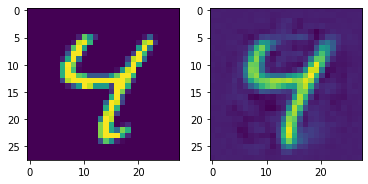

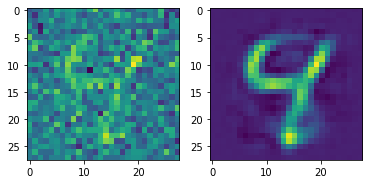

In [36]:
showEncodeDecode(dnauto_encode_decode_big, test_data_xy[6][0])
showEncodeDecode(dnauto_encode_decode_big, addNoise(test_data_xy[6][0]))

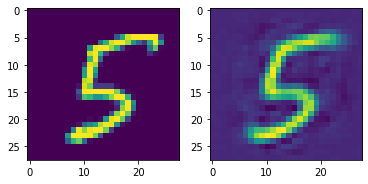

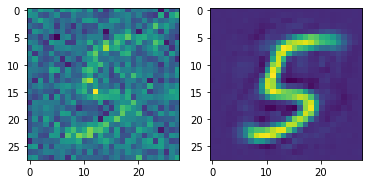

In [37]:
showEncodeDecode(dnauto_encode_decode_big, test_data_xy[23][0])
showEncodeDecode(dnauto_encode_decode_big, addNoise(test_data_xy[23][0]))

In [38]:
dnauto_encoder_dropout = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(p=0.2), #For the input we will usually drop only 5-20% of the values. 
    getLayer(D, D*2),
    nn.Dropout(), #By defult dropout uses 50% probability to zero-out values
    getLayer(D*2, D*2),
    nn.Dropout(),
    getLayer(D*2, D*2),
    nn.Dropout(),
    nn.Linear(D*2,  D*2)
)

dnauto_decoder_dropout = nn.Sequential(
    getLayer(D*2, D*2),
    nn.Dropout(),
    getLayer(D*2, D*2),
    nn.Dropout(),
    getLayer(D*2, D*2),
    nn.Dropout(),
    nn.Linear(D*2,  D),
    View(-1, 1, 28, 28)
)

dnauto_encode_decode_dropout = nn.Sequential(
    dnauto_encoder_big,
    dnauto_decoder_big
)
# Now we can train like normal. 
train_network(dnauto_encode_decode_dropout, mse_loss, train_loader, test_loader=test_loader, epochs=10, device=device)

,epoch,total time,train loss,test loss
0,0,9.096953,0.015096,0.010249
1,1,18.171283,0.014368,0.009365
2,2,27.258607,0.013803,0.009445
3,3,36.457156,0.014013,0.009219
4,4,45.674539,0.013731,0.008910
5,5,55.340990,0.012988,0.008614
6,6,64.530624,0.012727,0.008379
7,7,73.712708,0.012456,0.008317
8,8,82.912887,0.012530,0.008346
9,9,92.492231,0.012192,0.008053


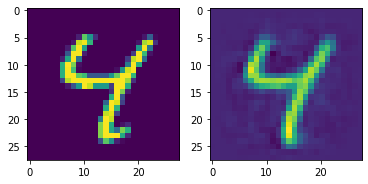

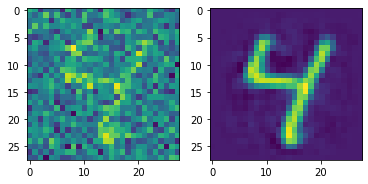

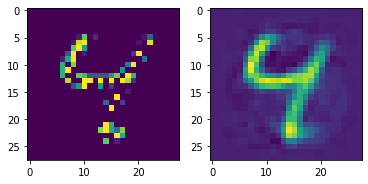

In [39]:
showEncodeDecode(dnauto_encode_decode_dropout, test_data_xy[6][0]) #Clean data
showEncodeDecode(dnauto_encode_decode_dropout, addNoise(test_data_xy[6][0])) #guassian noise
showEncodeDecode(dnauto_encode_decode_dropout, nn.Dropout()(test_data_xy[6][0])) #dropout noise

In [40]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

all_data = []
resp = urlopen("https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt")
shakespear_100k = resp.read()
shakespear_100k = shakespear_100k.decode('utf-8').lower()

In [41]:
vocab2indx = {} #the vocab $\Sigma$
for char in shakespear_100k: 
    if char not in vocab2indx: #add every new character to the vocab
        vocab2indx[char] = len(vocab2indx) #set the index based on the current vocab size

#Some useful code to goe from index back to original characters. 
indx2vocab = {}
#Well simply iterate over all key,value pairs and create a dicionary with the inverse mapping. 
for k, v in vocab2indx.items():
    indx2vocab[v] = k
print("Vocab Size: ", len(vocab2indx))
print("Total Characters:", len(shakespear_100k))

Vocab Size:  36
Total Characters: 99993


In [42]:
class AutoRegressiveDataset(Dataset):
    """
    Creates an autoregressive dataset from one single, long, source sequence by breaking it up into "chunks". 
    """

    def __init__(self, large_string, MAX_CHUNK=500):
        """
        large_string: the original long source sequence that chunks will be extracted from
        MAX_CHUNK: the maximum allowed size of any chunk. 
        """
        self.doc = large_string
        self.MAX_CHUNK = MAX_CHUNK

    def __len__(self):
        #The number of items is the number of characters divided by chunk size
        return (len(self.doc)-1) // self.MAX_CHUNK

    def __getitem__(self, idx):
        #Compute the starting position for the idx'th chunk
        start = idx*self.MAX_CHUNK
        #Grab the input sub-string
        sub_string = self.doc[start:start+self.MAX_CHUNK]
        #convert the sub-string into integers based on our vocab
        x = [vocab2indx[c] for c in sub_string]
        
        #grab the label sub-string by shifting over by 1
        sub_string = self.doc[start+1:start+self.MAX_CHUNK+1]
        #convert the label sub-string into integers based on our vocab
        y = [vocab2indx[c] for c in sub_string]
        #convert the 
        return torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)
#Caption: Creating a dataset for autoregressive problems from a large text corpus. We assume the corpus exists as one long string, and it is OK to concatenate multiple files together into one long string since our chunks are smaller than most documents are anyway. 

In [43]:
class AutoRegressive(nn.Module):

    def __init__(self, num_embeddings, embd_size, hidden_size, layers=1):
        super(AutoRegressive, self).__init__()
        self.hidden_size = hidden_size
        self.embd = nn.Embedding(num_embeddings, embd_size)
        self.layers = nn.ModuleList([nn.GRUCell(embd_size, hidden_size)] + 
                                     [nn.GRUCell(hidden_size, hidden_size) for i in range(layers-1)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])
        
        self.pred_class = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),# (B, *, D)
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size), # (B, *, D)
            nn.Linear(hidden_size, num_embeddings) #(B, *. D) -> B(B, *, VocabSize)
        )
        
    def initHiddenStates(self, B):
        """
        Creates an initial hidden state list for the RNN layers. 
        
        B: the batch size for the hidden states. 
        """
        return [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]
        
    def step(self, x_in, h_prevs=None):
        """
        x_in: the input for this current time step and has shape (B) if the values need 
            to be embedded, and (B, D) if they have alreayd been embedded. 

        h_prevs: a list of hidden state tensors each with shape (B, self.hidden_size) for each 
            layer in the network. These contain the current hidden state of the RNN layers and 
            will be updated by this call. 
        """
        #Prep all three arguments to be in the final form
        if len(x_in.shape) == 1: #(B), we need to embed it
            x_in = self.embd(x_in) #now (B, D)

        if h_prevs is None:
            h_prevs = self.initHiddenStates(x_in.shape[0])
        
        #Process the input 
        for l in range(len(self.layers)):
            h_prev = h_prevs[l]
            h = self.norms[l](self.layers[l](x_in, h_prev))

            h_prevs[l] = h
            x_in = h
        #Make predictions about the token
        return self.pred_class(x_in)
    
    def forward(self, input):
        #Input should be (B, T)
        #What is the batch size?
        B = input.size(0)
        #What is the max number of time steps?
        T = input.size(1)
        
        x = self.embd(input) #(B, T, D)
        
        #Initial hidden states
        h_prevs = self.initHiddenStates(B)
        
        last_activations = []
        for t in range(T):
            x_in = x[:,t,:] #(B, D)
            last_activations.append(self.step(x_in, h_prevs))
        
        last_activations = torch.stack(last_activations, dim=1) #(B, T, D)
        
        return last_activations

In [44]:
autoRegData = AutoRegressiveDataset(shakespear_100k, MAX_CHUNK=250)
autoReg_loader = DataLoader(autoRegData, batch_size=128, shuffle=True)

autoReg_model = AutoRegressive(len(vocab2indx), 32, 128, layers=2)
autoReg_model = autoReg_model.to(device)

for p in autoReg_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

In [45]:
def CrossEntLossTime(x, y):
    """
    x: output with shape (B, T, V)
    y: labels with shape (B, T)
    
    """
    cel = nn.CrossEntropyLoss()
    
    T = x.size(1)
    
    loss = 0
    
    for t in range(T):#for every item in the sequence
        loss += cel(x[:,t,:], y[:,t]) #Compute the sum of prediction errors
    
    return loss

In [46]:
train_network(autoReg_model, CrossEntLossTime, autoReg_loader, epochs=100, device=device)

,epoch,total time,train loss
0,0,1.435996,878.889908
1,1,2.824255,797.569443
2,2,4.211852,774.341064
3,3,5.597172,765.255081
4,4,6.982966,760.935104
...,...,...,...
95,95,142.997783,393.609581
96,96,144.496295,395.654900
97,97,145.997684,392.421410
98,98,147.491100,391.244034


In [47]:
autoReg_model = autoReg_model.eval()
sampling = torch.zeros((1, 500), dtype=torch.int64, device=device)

In [48]:
seed = "EMILIA:".lower()
cur_len = len(seed)
sampling[0,0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])

In [49]:
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i]) #process all the previous items
        h = h[:,-1,:] #Grab the last time step
        h = F.softmax(h, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1) #sample the next prediction
        sampling[:,i] = next_tokens #set the next prediction
        #increase the length by one
        cur_len += 1

In [50]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

emilia:
to hen the words tractass of nan wand,
no bear to the groung, iftink sand'd sack,
i will ciscling
bronino:
if this,
so you you may well you and surck, of wife where sooner you.

corforesrale:
where here of his not but rost lighter'd therefore latien ever
un'd
but master your brutures warry:
why,
thou do i mus shooth and,
rity see! more mill of cirfer put,
and her me harrof of that thy restration stucied the bear:
and quicutiand courth, for sillaniages:
so lobate thy trues not very repist


In [51]:
cur_len = len(seed)
temperature = 0.75 #Primary addition, controls the temperature and our sampling behavior
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i])
        h = h[:,-1,:] #Grab the last time step
        h = F.softmax(h/temperature, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens

        cur_len += 1

In [52]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

emilia:
therefore good i am to she prainns siefurers.

king ford:
beor come, sir, i chaed
to me, the was the strong arl and the boy fear mabber lord,,
coull some a clock dightle eyes, agaary must her was flord but the hear fall
the cousion a tarm:
i am a varstiend the her apper the service no that you shall give yet somantion, and lord, and commind cure, i why had they helbook.

mark ars:
who her throw true in go speect proves of the wrong and further gooland, before but i am so are berether, i 


In [53]:
cur_len = len(seed)
temperature = 0.05 #Very low temp, will almost always pick the most likely items. 
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i])
        h = h[:,-1,:] #Grab the last time step
        h = F.softmax(h/temperature, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens

        cur_len += 1
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))


emilia:
i will straight the shall shall shall be the with the shall shall shall shall be the with the shall be the with the shall shall shall be the shall shall shall she shall shall shall shall shall be the with the shall shall shall shall be the shall be the shall shall shall shall shall shall shall shall be the prove the will so see and the shall be the will the shall shall shall shall shall shall be the with the shall shall shall shall be the shall be the with the shall shall shall be the wi


In [54]:
#Set up our seed and the location to store the generated content
seed = "EMILIA:".lower()
cur_len = len(seed)
sampling = torch.zeros((1, 500), dtype=torch.int64, device=device)
sampling[0,0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])

#pick a temperature
temperature = 0.75
with torch.no_grad():
    #initialize the hidden state to avoid redundant work
    h_prevs = autoReg_model.initHiddenStates(1)
    #push the seed through
    for i in range(0, cur_len):
        h = autoReg_model.step(sampling[:,i], h_prevs=h_prevs)

    #generate new text one character at a time
    for i in tqdm(range(cur_len, sampling.size(1))):
        h = F.softmax(h/temperature, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens
        cur_len += 1
        #now push only the new sample into the model
        h = autoReg_model.step(sampling[:,i], h_prevs=h_prevs)

In [55]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

emilia:
a-to her hand by hath the stake my pouse of we to more should there had the would break fot his good, and me in deserved
to not days all the wead his to king; her fair the bear so word blatter with my hath thy hamber--

king dige:
it the recuse.

mark:
wey, he to o hath a griec, and could would there you honour fail;
have at i would straigh his boy:
coursiener:
and to refore so marry fords like i seep a party. or thee your honour great way we the may her with all the more ampiled my porn
